In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras.layers import Input, Dense, Lambda, InputLayer, concatenate
from keras.models import Model, Sequential
from keras import backend as K
from keras import metrics
from keras.datasets import mnist
from keras.utils import to_categorical

# Task 1

In [2]:
# load the data
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# scale the data
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [3]:
# matrix into vector
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [4]:
original_dim = x_train.shape[1]

## a)

From the lecture we know that ELBO equals

$$ELBO = \mathbb{E}_q \log p(x|z) - KL(q(z|x)||p(z)).$$

Assume that we already know the parameters of the encoder 

$$\mathbb{E}_q \log p(x|z) = \mathbb{E}_{\varepsilon} \log p(x|z_{\phi}(\varepsilon, x))$$

Below: 

 - `x` - observed vector of pixels (0 and 1)
 - `x_decoded` - $p(1|z_{\phi}(\varepsilon, x)) = p(1|\mu_{\phi}(x) + \Sigma_{\phi}(x)^{1/2}\varepsilon)$, where $\varepsilon$ was generated according to $\mathcal{N}(0, 1)$ - the aposteriori probability of the pixel being $1$ after reparametrization trick
 - $\Sigma_{\phi}(x) = \textrm{diag}(\sigma_{\phi, 1}^2(x), \sigma_{\phi, 2}^2, \ldots, \sigma_{\phi, K}^2)$
 - `z_mean` - $\mu_{\phi}(x) = (\mu_{\phi, 1}(x), \mu_{\phi, 2}(x), \ldots, \mu_{\phi, K}(x))$
 - `z_log_var` - $(\log\sigma_{\phi, 1}^2(x), \log\sigma_{\phi, 2}^2(x), \ldots, \log\sigma_{\phi, K}^2(x))$

 - $q(z|x) = \mathcal{N}(\mu_{\phi}(x), \Sigma_{\phi}(x))$

Input: `x, x_decoded, z_mean, z_log_var`

Output: ELBO

In [5]:
@tf.function
def elbo_vae(x, x_decoded, z_mean, z_log_var):

    loss_term = tf.reduce_sum(x * tf.math.log(x_decoded + 1e-19) + (1 - x) * tf.math.log(1 - x_decoded + 1e-19), 1)

    KL_term =  0.5 * tf.reduce_sum(-z_log_var + tf.exp(z_log_var) + tf.square(z_mean) - 1, 1)

    return tf.reduce_mean(loss_term - KL_term)

## b)

Next we need to get a sample from $q(z|x)$. We will use a reparametrization trick.

Input: `z_mean, z_log_var`

Output: $\mathcal{N}(\mu_{\phi}(x), \Sigma_{\phi}(x))$

In [6]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

## c)

A part of the model that takes input and returns a vector:

$$ (\mu_{\phi, 1}(x), \mu_{\phi, 2}(x), \ldots, \mu_{\phi, K}(x), \log\sigma_{\phi, 1}^2(x), \log\sigma_{\phi, 2}^2(x), \ldots, \log\sigma_{\phi, K}^2(x)) $$

Due to technical reason we will return the above vector and sampled values of $z$ as the output of the encoder (and not as a separate layer).

In [7]:
latent_dim = 10

encoder_inputs = keras.Input(shape=(original_dim))
x = Dense(256, activation='relu')(encoder_inputs)
x = Dense(256, activation='tanh')(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()


Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 784)]                0         []                            
                                                                                                  
 dense (Dense)               (None, 256)                  200960    ['input_1[0][0]']             
                                                                                                  
 dense_1 (Dense)             (None, 256)                  65792     ['dense[0][0]']               
                                                                                                  
 z_mean (Dense)              (None, 10)                   2570      ['dense_1[0][0]']             
                                                                                           

In [8]:
# number of parameters:
(784 + 1)*256, (256 + 1)*256, (256 + 1)*latent_dim

(200960, 65792, 2570)

## d)

In [9]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = Dense(256, activation='relu')(latent_inputs)
x = Dense(256, activation='tanh')(x)
decoder_outputs = Dense(original_dim, activation='sigmoid')(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 10)]              0         
                                                                 
 dense_2 (Dense)             (None, 256)               2816      
                                                                 
 dense_3 (Dense)             (None, 256)               65792     
                                                                 
 dense_4 (Dense)             (None, 784)               201488    
                                                                 
Total params: 270096 (1.03 MB)
Trainable params: 270096 (1.03 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## e)

In [10]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)

            total_loss = -elbo_vae(data, reconstruction, z_mean, z_log_var)           

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)

        return {"loss": self.total_loss_tracker.result()}        

In [11]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(x_train, epochs=10, batch_size=128)

Epoch 1/10
469/469 [==============================] - 5s 7ms/step - loss: 223.9128
Epoch 2/10
469/469 [==============================] - 3s 7ms/step - loss: 137.5125
Epoch 3/10
469/469 [==============================] - 3s 7ms/step - loss: 125.5346
Epoch 4/10
469/469 [==============================] - 3s 7ms/step - loss: 120.4228
Epoch 5/10
469/469 [==============================] - 3s 7ms/step - loss: 117.3548
Epoch 6/10
469/469 [==============================] - 4s 8ms/step - loss: 115.0758
Epoch 7/10
469/469 [==============================] - 3s 7ms/step - loss: 113.2549
Epoch 8/10
469/469 [==============================] - 4s 9ms/step - loss: 111.7200
Epoch 9/10
469/469 [==============================] - 4s 8ms/step - loss: 110.3890
Epoch 10/10
469/469 [==============================] - 4s 8ms/step - loss: 109.8476


## f)

In [12]:
# representation in the latent space of observations from test ds
# z_test_pred = # encoder predictions
z_mean, z_log_var, z_value = encoder.predict(x_test)



import matplotlib.pyplot as plt
def plot_images(original, decoded, n=10):
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(original[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()


313/313 [==============================] - 1s 2ms/step


313/313 [==============================] - 1s 2ms/step


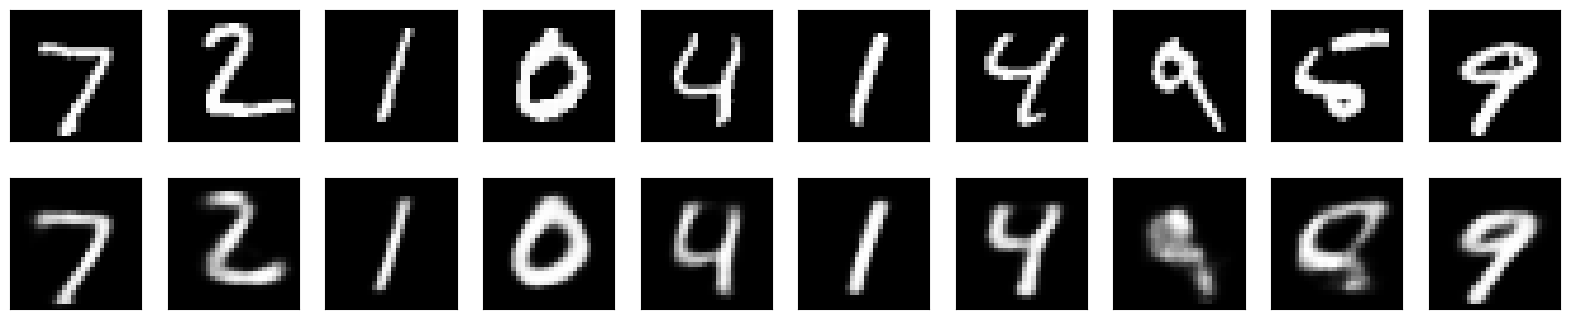

In [13]:
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs[2])
plot_images(x_test, decoded_imgs)

In [14]:
# in a list z_test_pred indeces mean: 0-vector of means, 1-vector of variances, 2-values in the latent space
# this is a prediction
z_test_pred = [z_mean, z_log_var, z_value]
test_pred = decoder.predict(z_value)
# decoder predictions - we take a vector from the latent space and transform it to be again a picture


313/313 [==============================] - 1s 2ms/step


In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

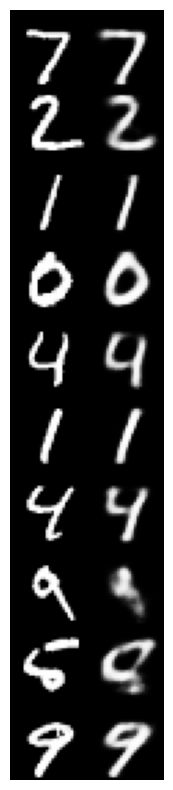

In [16]:
n = 10  # figure with 10 x 2 digits
digit_size = (np.sqrt(original_dim)).astype('int')
fig = plt.figure(figsize=(10, 10))
figure = np.zeros((digit_size * n, digit_size * 2))
decoded = test_pred

for i in range(10):
    figure[i * digit_size: (i + 1) * digit_size, :digit_size] = x_test[i, :].reshape(digit_size, digit_size)
    figure[i * digit_size: (i + 1) * digit_size, digit_size:] = decoded[i, :].reshape(digit_size, digit_size)
    
plt.imshow(figure, cmap='Greys_r')
plt.axis('off')
plt.show()


## g)

In [17]:
# use z_test_pred

In [18]:
from sklearn.manifold import TSNE

In [19]:
tsne = TSNE(n_components=2)

In [20]:
N=10000
z_test_pred_tsne = tsne.fit_transform(z_test_pred[0][:N,])

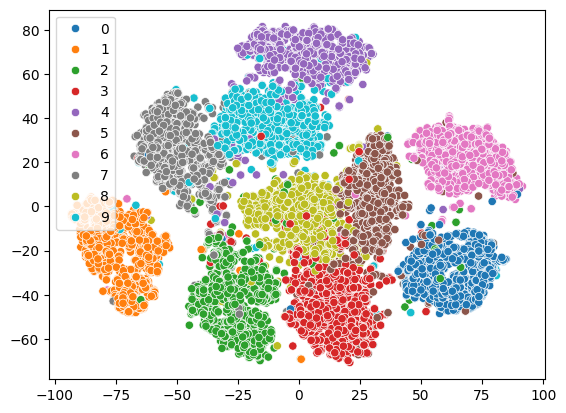

In [21]:
N=10000
sns.scatterplot(x=z_test_pred_tsne[:N,0], y=z_test_pred_tsne[:N,1], hue=y_test[:N], palette=sns.color_palette("tab10"))
plt.show()

## h)

In [22]:
def generate_new_images(num_images):
    # Sample from the standard normal distribution
    z_sample = np.random.normal(size=(num_images, latent_dim))
    # Generate images from the latent vectors
    generated_images = decoder.predict(z_sample)
    return generated_images.reshape(-1, 28, 28)  # Reshape to image dimensions

In [23]:
# Generate new images
new_images = generate_new_images(10)

1/1 [==============================] - 0s 27ms/step


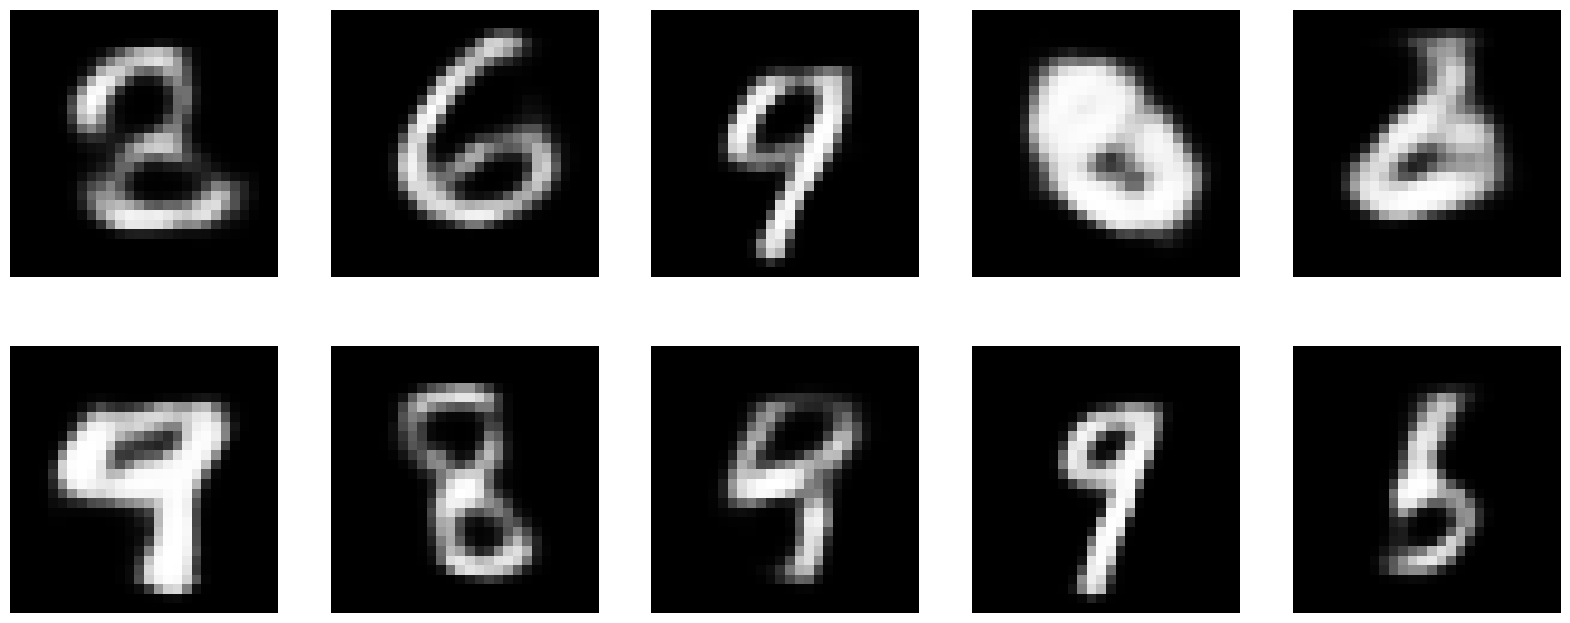

In [24]:
# Display new images
plt.figure(figsize=(20, 8))
for i in range(10):
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(new_images[i], cmap='gray')
    ax.axis('off')
plt.show()

## Task 2

In [25]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the latent vector."""
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [26]:
# Encoder definition
encoder_inputs = keras.Input(shape=(original_dim + 1))
x = layers.Dense(256, activation='relu')(encoder_inputs)
x = layers.Dense(256, activation='tanh')(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="c_encoder")
encoder.summary()

Model: "c_encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 785)]                0         []                            
                                                                                                  
 dense_5 (Dense)             (None, 256)                  201216    ['input_3[0][0]']             
                                                                                                  
 dense_6 (Dense)             (None, 256)                  65792     ['dense_5[0][0]']             
                                                                                                  
 z_mean (Dense)              (None, 10)                   2570      ['dense_6[0][0]']             
                                                                                          

In [27]:
# Decoder definition
latent_inputs = keras.Input(shape=(latent_dim + 1))
x = layers.Dense(256, activation='relu')(latent_inputs)
x = layers.Dense(256, activation='tanh')(x)
outputs = layers.Dense(original_dim, activation='sigmoid')(x)
decoder = keras.Model(latent_inputs, outputs, name="c_decoder")
decoder.summary()

Model: "c_decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 11)]              0         
                                                                 
 dense_7 (Dense)             (None, 256)               3072      
                                                                 
 dense_8 (Dense)             (None, 256)               65792     
                                                                 
 dense_9 (Dense)             (None, 784)               201488    
                                                                 
Total params: 270352 (1.03 MB)
Trainable params: 270352 (1.03 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [28]:
# cVAE model
class ConditionalVAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(ConditionalVAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")

    def train_step(self, data):
        x, c = data[:, :-1], data[:, -1:]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(tf.concat([x, c], axis=1))
            z_cond = tf.concat([z, c], axis=1)
            reconstruction = self.decoder(z_cond)

            total_loss = -elbo_vae(x, reconstruction, z_mean, z_log_var)           

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)

        return {"loss": self.total_loss_tracker.result()}  

In [29]:
cvae = ConditionalVAE(encoder, decoder)
cvae.compile(optimizer=keras.optimizers.Adam())
x_cond_train = np.hstack((x_train, y_train.reshape(-1,1)))
# cvae.fit(tf.concat([x_train, y_train[:, None]], 1), epochs=10, batch_size=128)

# Example data preparation
(x_train, y_train), _ = keras.datasets.mnist.load_data()
x_train = x_train.astype('float32') / 255
x_train = x_train.reshape(-1, original_dim)
y_train = y_train.astype('float32').reshape(-1, 1)
x_cond_train = np.hstack((x_train, y_train))

# Train the model
cvae.fit(x_cond_train, epochs=10, batch_size=128)

Epoch 1/10
469/469 [==============================] - 5s 7ms/step - loss: 218.4830
Epoch 2/10
469/469 [==============================] - 3s 7ms/step - loss: 140.6486
Epoch 3/10
469/469 [==============================] - 5s 10ms/step - loss: 127.7138
Epoch 4/10
469/469 [==============================] - 4s 9ms/step - loss: 121.2264
Epoch 5/10
469/469 [==============================] - 4s 9ms/step - loss: 117.1376
Epoch 6/10
469/469 [==============================] - 4s 9ms/step - loss: 114.3133
Epoch 7/10
469/469 [==============================] - 4s 8ms/step - loss: 112.5645
Epoch 8/10
469/469 [==============================] - 4s 8ms/step - loss: 110.8073
Epoch 9/10
469/469 [==============================] - 4s 8ms/step - loss: 109.8806
Epoch 10/10
469/469 [==============================] - 4s 8ms/step - loss: 108.7908


## f)

In [30]:

(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_test = x_test.astype('float32') / 255
original_dim = 28 * 28
x_test = x_test.reshape(-1, original_dim)
y_test = y_test.astype('float32').reshape(-1, 1)
x_cond_test = np.hstack((x_test, y_test))
z_mean, z_log_var, z_test_pred_c = cvae.encoder.predict(x_cond_test)

latent_input_with_labels = np.hstack((z_test_pred_c, y_test))
test_pred_c = cvae.decoder.predict(latent_input_with_labels)

313/313 [==============================] - 1s 2ms/step


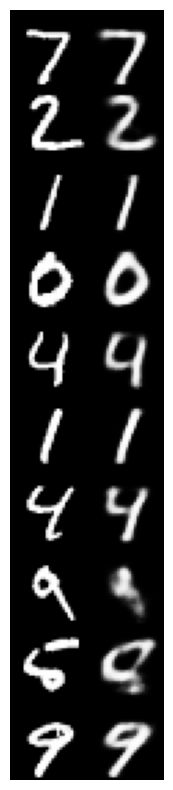

In [31]:
n = 10  # figure with 10 x 2 digits
digit_size = (np.sqrt(original_dim)).astype('int')
fig = plt.figure(figsize=(10, 10))
figure = np.zeros((digit_size * n, digit_size * 2))
decoded = test_pred

for i in range(10):
    figure[i * digit_size: (i + 1) * digit_size, :digit_size] = x_test[i, :].reshape(digit_size, digit_size)
    figure[i * digit_size: (i + 1) * digit_size, digit_size:] = decoded[i, :].reshape(digit_size, digit_size)
    
plt.imshow(figure, cmap='Greys_r')
plt.axis('off')
plt.show()

## g

<Axes: >

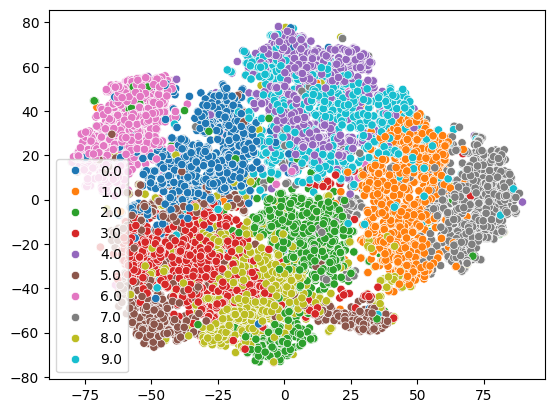

In [32]:
# Apply TSNE on the predicted latent vectors
N = 10000
z_test_pred_tsne_c = tsne.fit_transform(z_test_pred_c[:N, :])

# Visualize with seaborn
sns.scatterplot(x=z_test_pred_tsne_c[:, 0], y=z_test_pred_tsne_c[:, 1], hue=y_test[:N, 0], palette=sns.color_palette("tab10"))

## h)

1/1 [==============================] - 0s 30ms/step


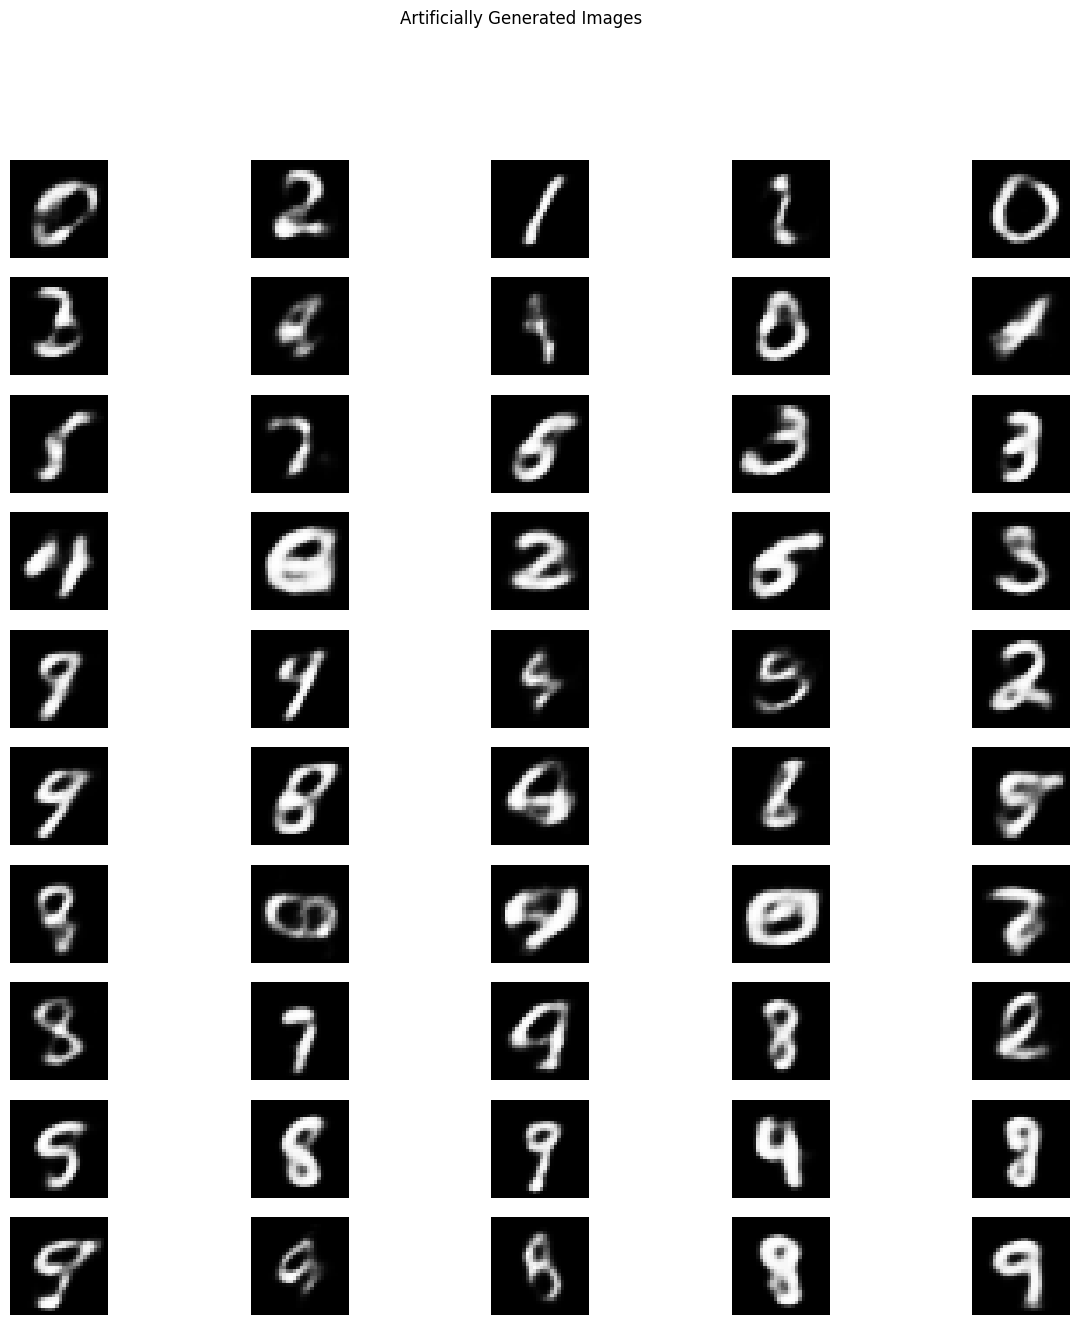

In [33]:
# Function to generate new images from the prior distribution
def generate_samples_from_prior(decoder, latent_dim=2, n_classes=10, n_samples_per_class=5):
    """Generate samples from the prior distribution using the decoder."""
    new_images = []
    for digit in range(n_classes):
        # Sample latent vectors from the prior (Gaussian)
        z_prior = np.random.normal(size=(n_samples_per_class, latent_dim))
        # Concatenate the class label
        labels = np.full((n_samples_per_class, 1), digit)
        z_cond = np.hstack((z_prior, labels))
        # Generate new samples using the decoder
        decoded_images = decoder.predict(z_cond)
        new_images.extend(decoded_images)
    return np.array(new_images)

# Generate new samples conditioned on classes
n_classes = 10
n_samples_per_class = 5
generated_images = generate_samples_from_prior(cvae.decoder, latent_dim=10, n_classes=n_classes, n_samples_per_class=n_samples_per_class)

# Visualize the results - artificially generated images
fig, axs = plt.subplots(n_classes, n_samples_per_class, figsize=(15, 15))
fig.suptitle("Artificially Generated Images")
digit_size = int(np.sqrt(original_dim))

for i in range(n_classes):
    for j in range(n_samples_per_class):
        axs[i, j].imshow(generated_images[i * n_samples_per_class + j].reshape(digit_size, digit_size), cmap='Greys_r')
        axs[i, j].axis('off')

plt.show()